In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata

try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

X = mnist.data / 255.0
y = mnist.target

print(X.shape, y.shape)

(70000, 784) (70000,)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, X_test.shape)

(49000, 784) (21000, 784)


In [3]:
#https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from sklearn.decomposition import PCA
import pandas as pd
import time

start = time.time()
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train)

df = pd.DataFrame()

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
pca_result = df.values

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
end = time.time()
print(end - start)

Explained variation per principal component: [0.09811762 0.0716122  0.0615541 ]
1.6226954460144043


In [3]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 49000 samples in 6.412s...
[t-SNE] Computed neighbors for 49000 samples in 3230.943s...
[t-SNE] Computed conditional probabilities for sample 1000 / 49000
[t-SNE] Computed conditional probabilities for sample 2000 / 49000
[t-SNE] Computed conditional probabilities for sample 3000 / 49000
[t-SNE] Computed conditional probabilities for sample 4000 / 49000
[t-SNE] Computed conditional probabilities for sample 5000 / 49000
[t-SNE] Computed conditional probabilities for sample 6000 / 49000
[t-SNE] Computed conditional probabilities for sample 7000 / 49000
[t-SNE] Computed conditional probabilities for sample 8000 / 49000
[t-SNE] Computed conditional probabilities for sample 9000 / 49000
[t-SNE] Computed conditional probabilities for sample 10000 / 49000
[t-SNE] Computed conditional probabilities for sample 11000 / 49000
[t-SNE] Computed conditional probabilities for sample 12000 / 49000
[t-SNE] Computed conditional probabilities for

In [4]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("ticks")

from tqdm import trange, tqdm

# import operator
import matplotlib.colors as colors
import matplotlib.cm as cmx

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

select = tf.select if hasattr(tf, 'select') else tf.where

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [5]:
# Data params
input_dim = 3
output_dim = 10

# Network params
n_hidden_units = 43
#activation_fn = tf.nn.relu

# Optimization params
batch_size = 64
epochs_per_task = 10

n_stats = 1

# Reset optimizer after each age
reset_optimizer = True

## Construct datasets

In [31]:
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = pca_result[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        data = pca_result[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)

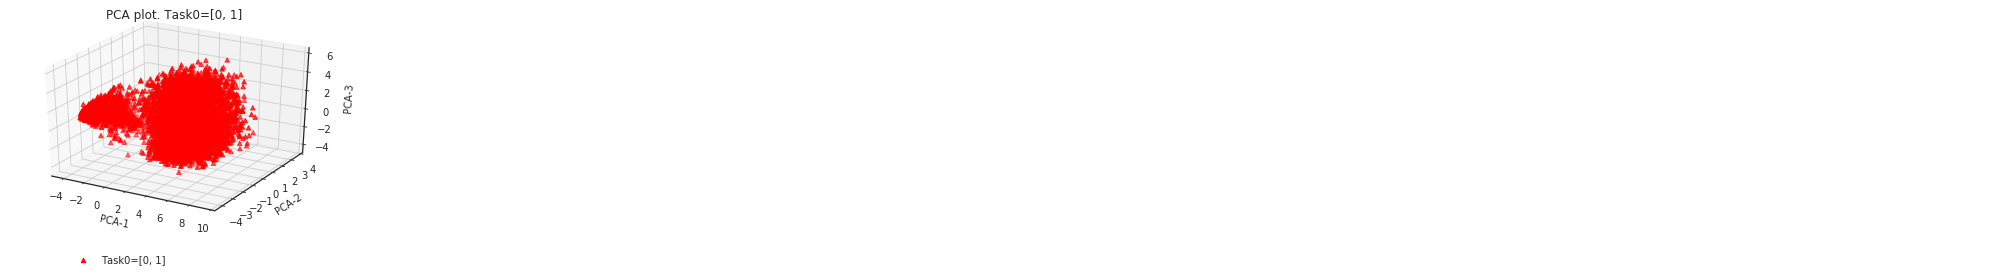

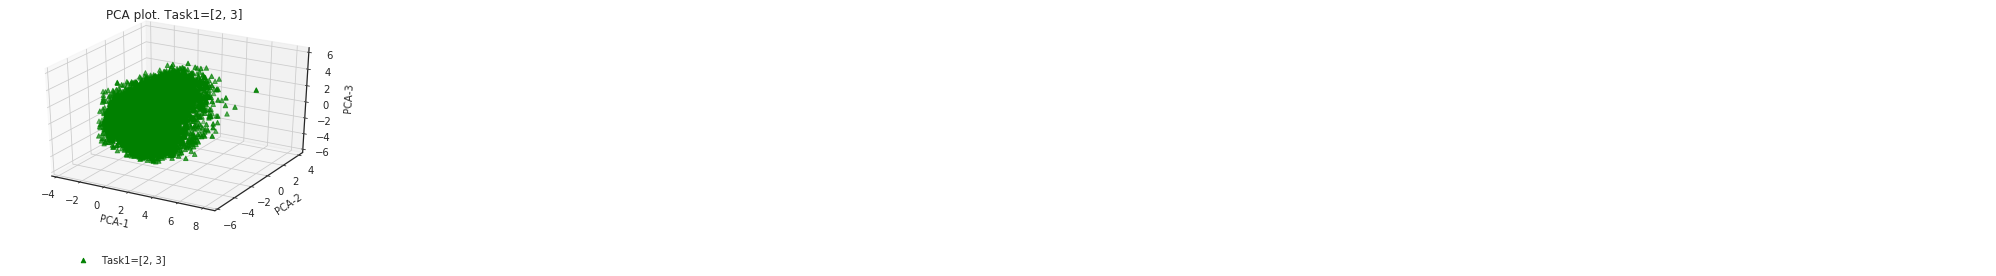

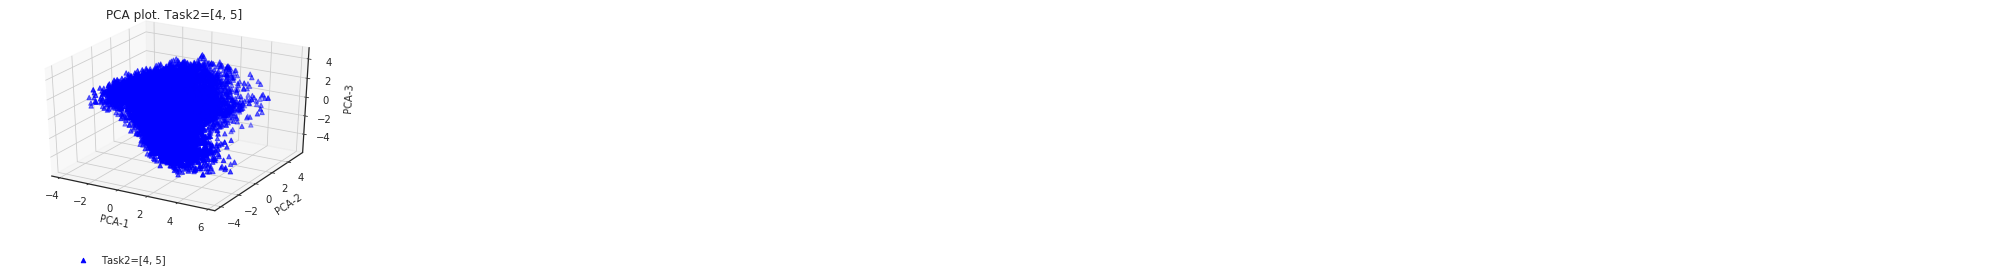

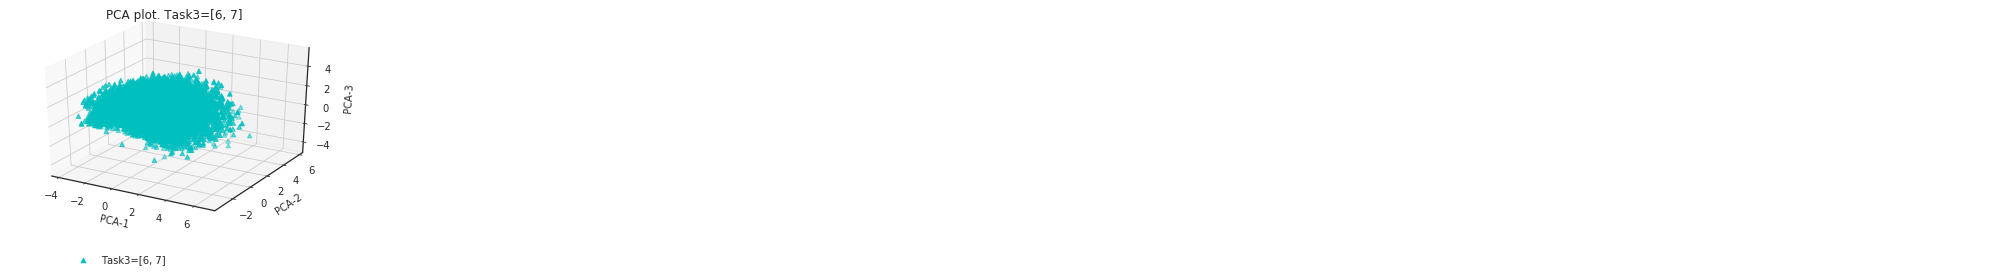

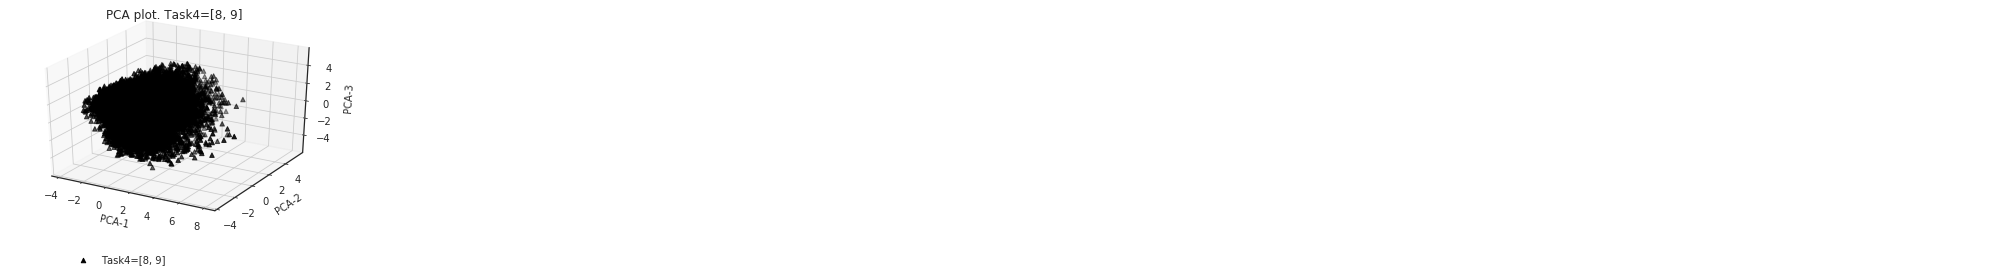

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

C=['r','g','b','c','k']

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for i in range(n_tasks):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = training_datasets[i][0][:,0]
    ys = training_datasets[i][0][:,1]
    zs = training_datasets[i][0][:,2]
    ax.scatter(xs, ys, zs, c=C[i], marker='^', label = 'Task'+str(i)+ "="+str(task_labels[i]))

    ax.set_xlabel('PCA-1')
    ax.set_ylabel('PCA-2')
    ax.set_zlabel('PCA-3')
    ax.legend(bbox_to_anchor=(0.5, -0.1))
    ax.set_title('PCA plot. Task'+str(i)+ "="+str(task_labels[i]))
    plt.savefig('pca-MNIST-task'+str(i)+'.pdf')

plt.show()

In [6]:
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = tsne_results[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        data = tsne_results[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)

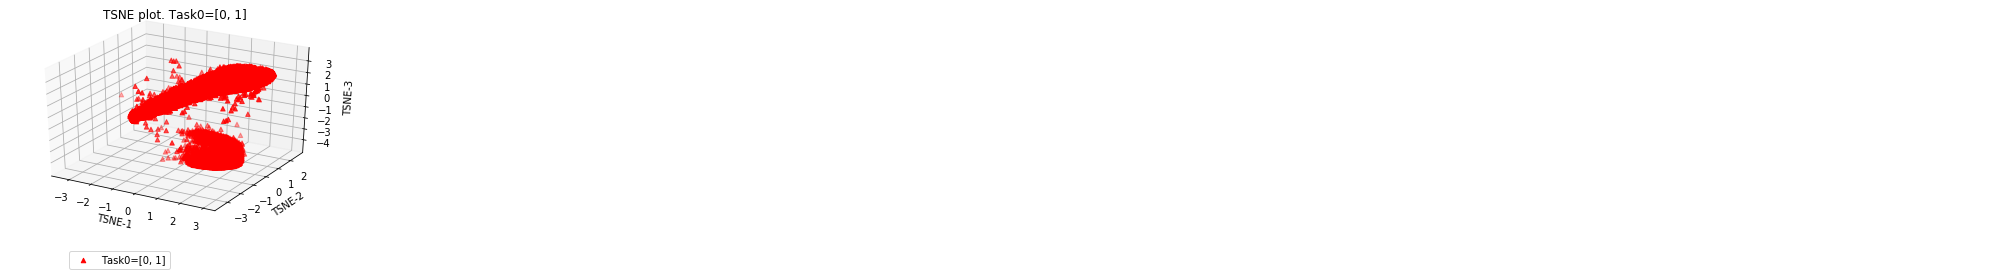

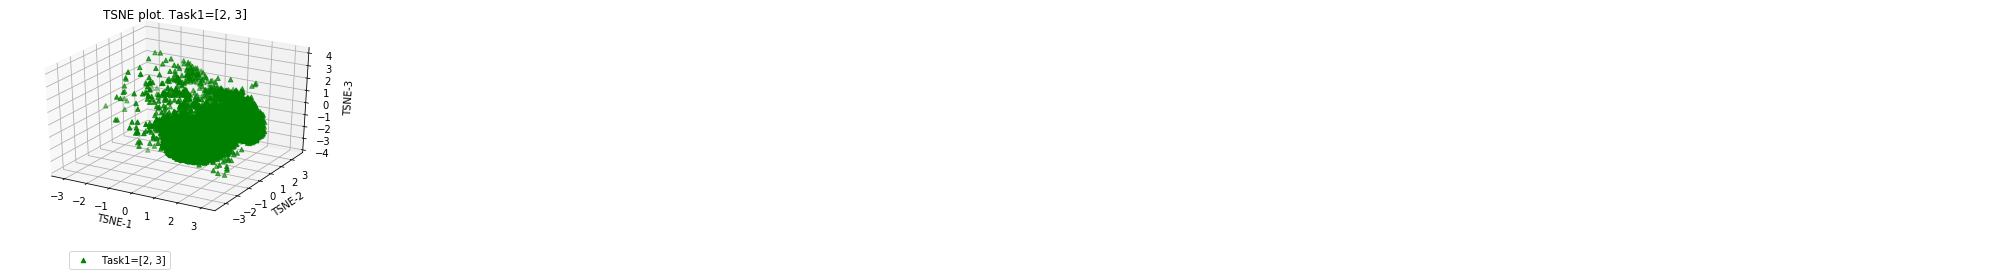

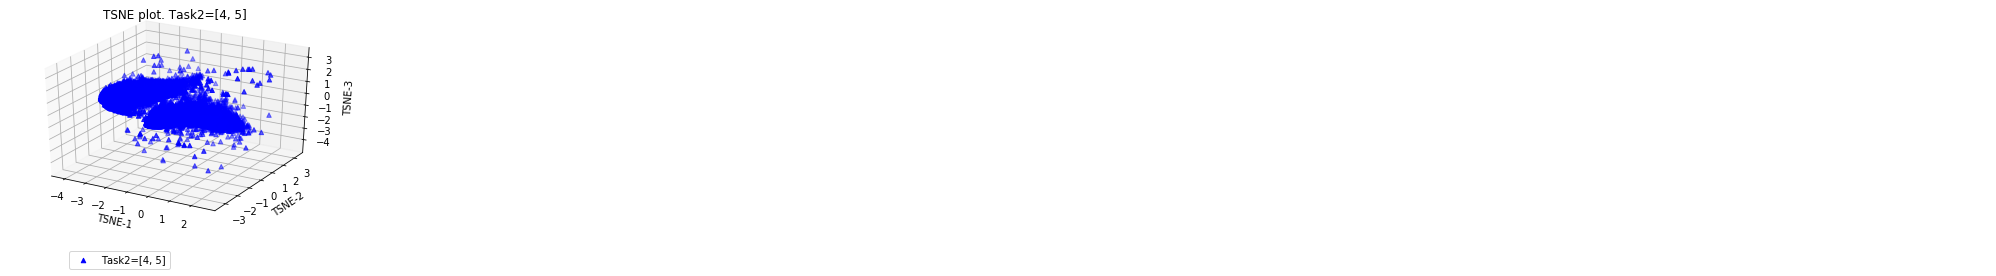

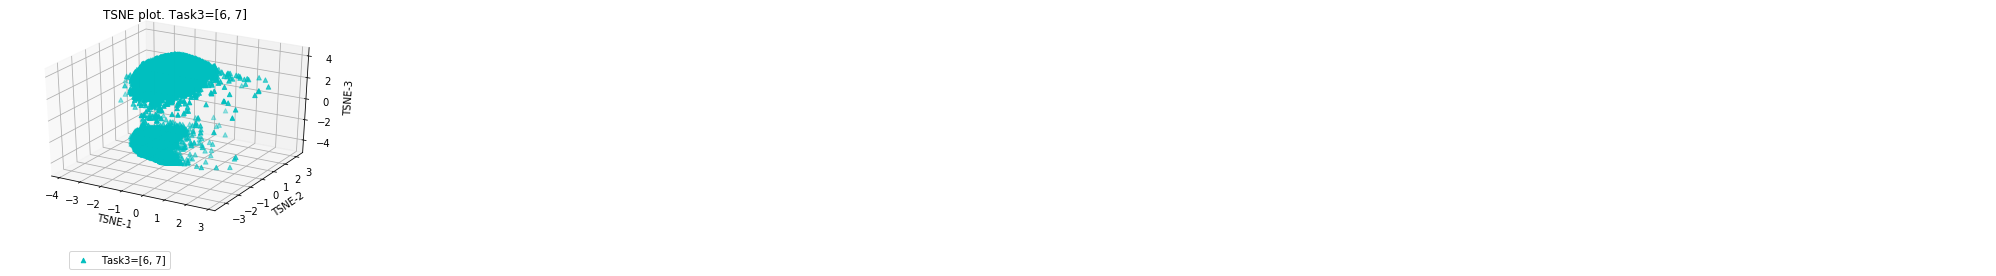

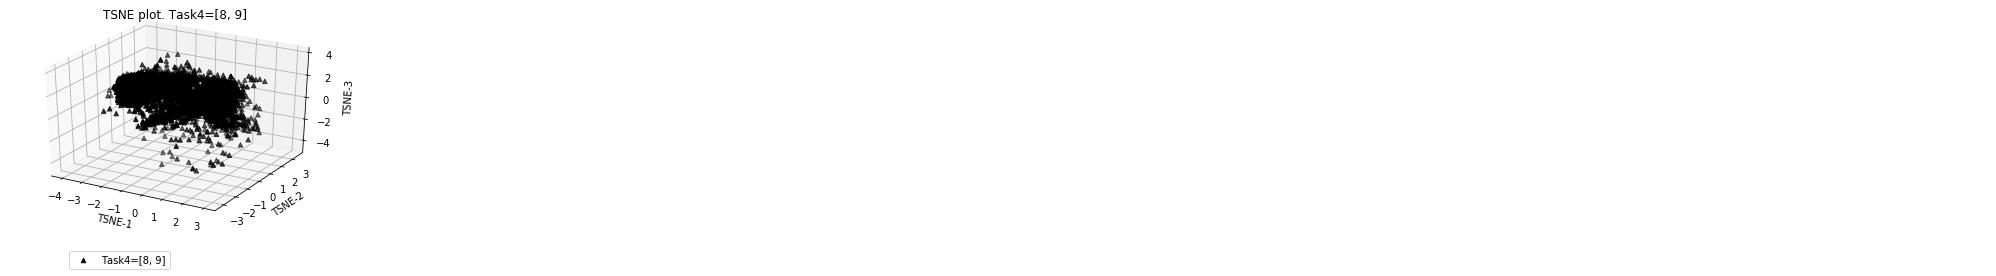

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

C=['r','g','b','c','k']

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for i in range(n_tasks):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = training_datasets[i][0][:,0]
    ys = training_datasets[i][0][:,1]
    zs = training_datasets[i][0][:,2]
    ax.scatter(xs, ys, zs, c=C[i], marker='^', label = 'Task'+str(i)+ "="+str(task_labels[i]))

    ax.set_xlabel('TSNE-1')
    ax.set_ylabel('TSNE-2')
    ax.set_zlabel('TSNE-3')
    ax.legend(bbox_to_anchor=(0.5, -0.1))
    ax.set_title('TSNE plot. Task'+str(i)+ "="+str(task_labels[i]))
    plt.savefig('TSNE-MNIST-task'+str(i)+'.pdf')

plt.show()

In [4]:
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
#With Approximation
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
This file is part of the HUB TOOLBOX available at
http://ofai.at/research/impml/projects/hubology.html
Source code is available at
https://github.com/OFAI/hub-toolbox-python3/
The HUB TOOLBOX is licensed under the terms of the GNU GPLv3.
(c) 2011-2016, Dominik Schnitzer and Roman Feldbauer
Austrian Research Institute for Artificial Intelligence (OFAI)
Contact: <roman.feldbauer@ofai.at>
This file is based on a Matlab script by Elizaveta Levina, University of 
Michigan, available at http://dept.stat.lsa.umich.edu/~elevina/mledim.m
Reference:  E. Levina and P.J. Bickel (2005).  
 "Maximum Likelihood Estimation  of Intrinsic Dimension."  
 In Advances in NIPS 17, Eds. L. K. Saul, Y. Weiss, L. Bottou. 
"""
import sys
import numpy as np
import pdb

def intrinsic_dimension(X:np.ndarray, k1:int=6, k2:int=12, 
                        estimator:str='levina', metric:str='vector', 
                        trafo:str='var', mem_threshold:int=5000):
    """Calculate intrinsic dimension based on the MLE by Levina and Bickel [1]_.
    
    Parameters
    ----------
    X : ndarray
        - An ``m x n`` vector data matrix with ``n`` objects in an 
          ``m`` dimensional feature space 
        - An ``n x n`` distance matrix.
        
        NOTE: The type must be defined via parameter `metric`!
        
    k1 : int, optional (default: 6)
        Start of neighborhood range to search in.
        
    k2 : int, optional (default: 12)
        End of neighborhood range to search in.
        
    estimator : {'levina', 'mackay'}, optional (default: 'levina')
        Determine the summation strategy: see [2]_.
    
    metric : {'vector', 'distance'}, optional (default: 'vector')
        Determine data type of `X`. 
        
        NOTE: the MLE was derived for euclidean distances. Using 
        other dissimilarity measures may lead to undefined results.
        
    trafo : {None, 'std', 'var'}, optional (default: 'var')
        Transform vector data. 
        
        - None: no transformation
        - 'std': standardization 
        - 'var': subtract mean, divide by variance (default behavior of 
          Laurens van der Maaten's DR toolbox; most likely for other 
          ID/DR techniques).
    mem_treshold : int, optional, default: 5000
        Controls speed-memory usage trade-off: If number of points is higher
        than the given value, don't calculate complete distance matrix at
        once (fast, high memory), but per row (slower, less memory).
    Returns
    -------
    d_mle : int
        Intrinsic dimension estimate (rounded to next integer)
    
    References
    ----------
    .. [1] Levina, E., & Bickel, P. (2004). Maximum likelihood estimation of 
           intrinsic dimension. Advances in Neural Information …, 17, 777–784. 
           http://doi.org/10.2307/2335172
    .. [2] http://www.inference.phy.cam.ac.uk/mackay/dimension/
    """
    n = X.shape[0]
    if estimator not in ['levina', 'mackay']:
        raise ValueError("Parameter 'estimator' must be 'levina' or 'mackay'.")
    if k1 < 1 or k2 < k1 or k2 >= n:
        raise ValueError("Invalid neighborhood: Please make sure that "
                         "0 < k1 <= k2 < n. (Got k1={} and k2={}).".
                         format(k1, k2))
    X = X.copy().astype(float)
        
    if metric == 'vector':
        # New array with unique rows   
        X = X[np.lexsort(np.fliplr(X).T)]
        
        if trafo is None:
            pass
        elif trafo == 'var':
            X -= X.mean(axis=0) # broadcast
            X /= X.var(axis=0) + 1e-7 # broadcast
        elif trafo == 'std':
            # Standardization
            X -= X.mean(axis=0) # broadcast
            X /= X.std(axis=0) + 1e-7 # broadcast
        else:
            raise ValueError("Transformation must be None, 'std', or 'var'.")
        
        # Compute matrix of log nearest neighbor distances
        X2 = (X**2).sum(1)
        
        
        distance = X2.reshape(-1, 1) + X2 - 2*np.dot(X, X.T) #2x br.cast
        distance.sort(1)
        # Replace invalid values with a small number
        distance[distance<=0] = 1e-7
        
        try:
            knnmatrix = .5 * np.log(distance[:, 1:k2+1])
        except:
            print('log caluclation error')
        
    
    elif metric == 'distance':
        raise NotImplementedError("ID currently only supports vector data.")
        #=======================================================================
        # # TODO calculation WRONG
        # X.sort(1)
        # X[X < 0] = 1e-7
        # knnmatrix = np.log(X[:, 1:k2+1])
        #=======================================================================
    elif metric == 'similarity':
        raise NotImplementedError("ID currently only supports vector data.")
        #=======================================================================
        # # TODO calculation WRONG
        # print("WARNING: using similarity data may return "
        #       "undefined results.", file=sys.stderr)
        # X[X < 0] = 0
        # distance = 1 - (X / X.max())
        # knnmatrix = np.log(distance[:, 1:k2+1])
        #=======================================================================
    else:
        raise ValueError("Parameter 'metric' must be 'vector' or 'distance'.")
    
    # Compute the ML estimate
    S = np.cumsum(knnmatrix, 1)
    indexk = np.arange(k1, k2+1) # broadcasted afterwards
    try:
        dividor = S[:, k1-1:k2] - knnmatrix[:, k1-1:k2] * indexk
        dhat = -(indexk - 2) / dividor
        dhat[dhat < -n*X.shape[1]] = 0
        dhat[dhat > n*X.shape[1]] = 0
    except:
        print('dhat calculation error')
    
    if estimator == 'levina':  
        # Average over estimates and over values of k
        no_dims = dhat.mean()
    if estimator == 'mackay':
        # Average over inverses
        dhat **= -1
        dhat_k = dhat.mean(0)
        no_dims = (dhat_k ** -1).mean()       
    no_dims = np.nan_to_num(no_dims)
    return int(no_dims.round())
    

class IntrinsicDim(): # pragma: no cover
    """
    .. note:: Deprecated in hub-toolbox 2.3
              Class will be removed in hub-toolbox 3.0.
              Please use static functions instead.
    """
       
    def __init__(self, X, data_type='vector'):
        """
        .. note:: Deprecated in hub-toolbox 2.3
                  Class will be removed in hub-toolbox 3.0.
                  Please use static functions instead.
        """
        # Deep copy required due to changes in vector data
        self.X = X.copy()
        if data_type in ['vector', 'distance', 'similarity']:
            self.data_type = data_type
            if data_type != 'vector':
                raise NotImplementedError("IntrinsicDim currently only "
                                          "supports vector data.")
        else:
            raise ValueError("Parameter data_type must be 'vector', 'distance'"
                             " , or 'similarity'. Got '{}' instead.".
                             format(data_type.__str__())) 

    def calculate_intrinsic_dimensionality(self, k1=6, k2=12, 
                                           estimator='levina'):
        """
        .. note:: Deprecated in hub-toolbox 2.3
                  Class will be removed in hub-toolbox 3.0.
                  Please use static functions instead.
        """
        print("DEPRECATED: Please use IntrinsicDim.intrinsic_dimension().", 
              file=sys.stderr)
        return intrinsic_dimension(self.X, k1, k2, estimator, self.data_type)
    
if __name__ == '__main__':
    for i in range(n_tasks):
        VECT_DATA = training_datasets[i][0]
        m_dim = VECT_DATA.shape[0]
        n_dim = VECT_DATA.shape[1]
        window_size = 50000
        if m_dim > window_size:
            m_dim = window_size
            VECT_DATA = VECT_DATA[:window_size,:]
        id_ = intrinsic_dimension(VECT_DATA)
        print("Task {}, {}x{} matrix: ID_MLE = {}".format(i,m_dim, n_dim, id_))

Task 0, 10447x784 matrix: ID_MLE = 1934
Task 1, 9893x784 matrix: ID_MLE = 553
Task 2, 9119x784 matrix: ID_MLE = 139
Task 3, 9871x784 matrix: ID_MLE = 1765
Task 4, 9670x784 matrix: ID_MLE = 1093


In [10]:
#Variance of each task's pca
from keras.utils import np_utils

#task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9],[1,5],[7,9],[3,8],[0,6],[4,2]]
#task_labels = [[8,9], [6,7], [4,5], [2,3], [0,1]]
#task_labels = [[0,9], [7,8], [3,6], [1,4], [2,5]]
#task_labels = [[0,1,2], [3,4,5], [6,7,8,9]]
#task_labels = [[1,5,8],[2,5,7,9],[3,4,6]]
task_labels = [[0,1], [2,3], [4,5], [6,7], [8,9]]
n_tasks = len(task_labels)
nb_classes  = 10
training_datasets = []
validation_datasets = []
multihead=False

for labels in task_labels:
    idx = np.in1d(Y_train, labels)
    if multihead:
        label_map = np.arange(nb_classes)
        label_map[labels] = np.arange(len(labels))
        data = X_train[idx], np_utils.to_categorical(label_map[Y_train[idx]], len(labels))
    else:
        data = X_train[idx], np_utils.to_categorical(Y_train[idx], nb_classes)
        training_datasets.append(data)
        
for i in range(n_tasks):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(training_datasets[i][0])

    df = pd.DataFrame()

    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1] 
    df['pca-three'] = pca_result[:,2]
    pca_result = df.values

    print('Task {} Explained variation per principal component: {}'.format(i,pca.explained_variance_ratio_))

Task 0 Explained variation per principal component: [0.32145691 0.09005737 0.0801857 ]
Task 1 Explained variation per principal component: [0.13721597 0.07631565 0.06023257]
Task 2 Explained variation per principal component: [0.12149055 0.09906549 0.05838287]
Task 3 Explained variation per principal component: [0.1948577  0.08199391 0.0655104 ]
Task 4 Explained variation per principal component: [0.11898749 0.08980842 0.06893655]
